This notebook is a test to compare float grounding pressure with bathymetry products, on a specific region  
__author__ = 'kevin.balem@ifremer.fr'
Here's the 1st plan :
- Get float index
- Subset region of interest
- Get/Set floats url
- Xarray open if files exists, and preprocess at max
- Subset again region of interest
- Interp etopo at cycles positions
- Map both bathy and difference
- Stat it (deviationS, errors, ...)

In [ ]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import scipy.interpolate as interpolate
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

In [2]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': np.str, 'profiler_type': np.str, 'institution': np.str}
                )
ix.tail()

,file,date,latitude,longitude,ocean,profiler_type,institution,update
2527166,nmdis/2901633/profiles/R2901633_067.nc,2.013050e+13,27.462000,139.106995,P,841,NM,20130507103443
2527167,nmdis/2901633/profiles/R2901633_068.nc,2.013051e+13,27.431999,138.839996,P,841,NM,20130511165723
2527168,nmdis/2901633/profiles/R2901633_069.nc,2.013052e+13,27.691999,138.677002,P,841,NM,20130521170139
2527169,nmdis/2901633/profiles/R2901633_070.nc,2.013053e+13,27.895000,138.464996,P,841,NM,20130531181516
2527170,nmdis/2901633/profiles/R2901633_071.nc,2.013061e+13,27.931000,138.089996,P,841,NM,20130617181801


In [ ]:
roi = np.array([-60.0,-21.0,45.0,63.0])
ixs = ix[(ix['latitude']>roi[2])&(ix['latitude']<roi[3]) & 
         (ix['longitude']>roi[0])&(ix['longitude']<roi[1])&
         ((ix['profiler_type']=='838'))]
#         ((ix['profiler_type']=='844')|(ix['profiler_type']=='838'))]
ixs = ixs.reset_index().drop(columns='index')

dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[f.split('/')[1] for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').max().reset_index()
ixs.tail()

In [121]:
# MODE BOURRIN POUR LE MOMENT, à SKIPPER LES FLOTTEURS OU IL Y A UN SOUCIS
df = xr.Dataset({"LATITUDE":(["N_PROF"],[]),"LONGITUDE": (["N_PROF"],[]),"WMO": (["N_PROF"],[]),"Zg": (["N_PROF"],[]), "Zp": (["N_PROF"],[])},coords={})
for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"   
    urld="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_prof.nc"
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)        
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]
            try:
                grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]
            except KeyError:
                try:
                    grounded = dt['CYCLE_NUMBER_ACTUAL'].values[cycles_grounded]
                except KeyError:
                    grounded = []
        except:
            #print('issue on : '+urlt)
            pass
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()
                # GROUNDING DATE > PARKING DRIFT END ?
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                
                dd = xr.open_dataset(urld)
                # PROFILE DATA
                ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,
                                                                dg['CYCLE_NUMBER'].values)])[['PRES','JULD','CYCLE_NUMBER',
                                                                                              'LATITUDE','LONGITUDE']].groupby('CYCLE_NUMBER').last()               
                # MAX PRES AND DEPTH CALCULATION for ds and dg
                ds = ds.max('N_LEVELS')
                ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_PROF",ds['LATITUDE'].values),
                                   "LONGITUDE":("N_PROF",ds['LONGITUDE'].values),
                                   "WMO":("N_PROF",np.zeros_like(ds['LONGITUDE'].values)+int(ixs['wmo'][i])),
                                   "Zg": ("N_PROF",dg['Z'].values),
                                   "Zp": ("N_PROF",ds['Z'].values)},coords={})
                    
                df=xr.concat([df,dtmp],dim='N_PROF')
            except:
                #print('issue on : '+urld) 
                pass

In [122]:
df = df.where((df['LONGITUDE']>roi[0])&(df['LONGITUDE']<roi[1])&(df['LATITUDE']>roi[2])&(df['LATITUDE']<roi[3]),drop=True)
df = df.sortby('LONGITUDE')
df

<xarray.Dataset>
Dimensions:    (N_PROF: 1304)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float64 58.73 59.41 60.79 58.33 ... 49.36 46.09 49.56
    LONGITUDE  (N_PROF) float64 -58.1 -57.9 -57.9 ... -21.96 -21.78 -21.57
    WMO        (N_PROF) float64 6.903e+06 6.903e+06 ... 6.902e+06 6.903e+06
    Zg         (N_PROF) float64 2.839e+03 2.808e+03 ... 3.931e+03 3.838e+03
    Zp         (N_PROF) float64 2.838e+03 2.809e+03 ... 3.918e+03 3.835e+03

In [123]:
# SPREAD BATHY : Array of random points around position to interpolate bathy
from cartopy.geodesic import Geodesic

PTS=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                           lat=df['LATITUDE'].isel(N_PROF=i).values,
                                           radius=100.,
                                           n_samples=25.)) for i in range(len(df['N_PROF']))])

radius = 2000.0 #in meters
radrange  = np.linspace(200,radius,6)
for r in radrange:
    PT0=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                               lat=df['LATITUDE'].isel(N_PROF=i).values,
                                               radius=r,
                                               n_samples=50.)) for i in range(len(df['N_PROF']))])
    PTS = np.column_stack((PTS,PT0))

x=xr.DataArray(PTS[:,:,0],dims=['N_PROF','PTS'])
y=xr.DataArray(PTS[:,:,1],dims=['N_PROF','PTS'])
spread_bathy = xr.Dataset()
spread_bathy['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
spread_bathy['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
spread_bathy

<xarray.Dataset>
Dimensions:  (N_PROF: 1304, PTS: 325)
Coordinates:
    x        (N_PROF, PTS) float64 -58.1 -58.1 -58.1 ... -21.56 -21.57 -21.57
    y        (N_PROF, PTS) float64 58.73 58.73 58.73 58.73 ... 49.58 49.58 49.58
    lon      (N_PROF, PTS) float64 -58.1 -58.1 -58.1 ... -21.56 -21.57 -21.57
    lat      (N_PROF, PTS) float64 58.73 58.73 58.73 58.73 ... 49.58 49.58 49.58
Dimensions without coordinates: N_PROF, PTS
Data variables:
    etopo    (N_PROF, PTS) float64 2.764e+03 2.763e+03 ... 3.816e+03 3.817e+03
    gebco    (N_PROF, PTS) float64 2.771e+03 2.771e+03 ... 3.842e+03 3.846e+03

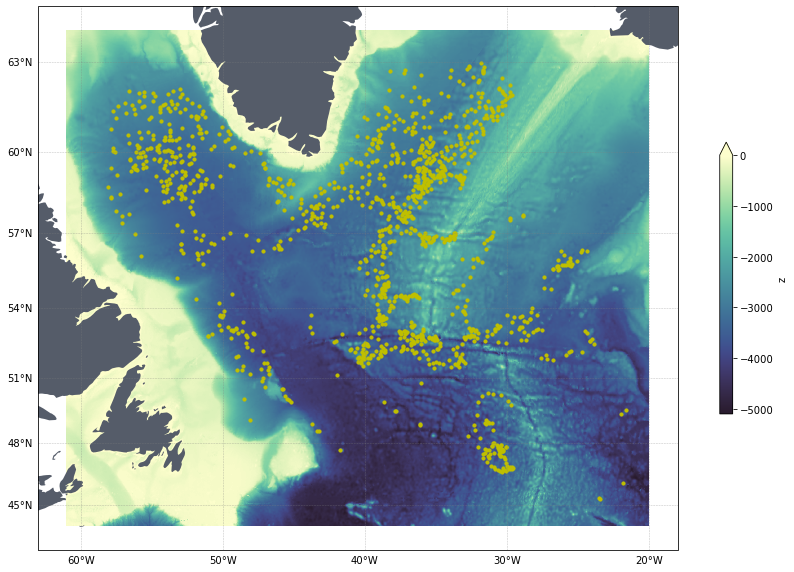

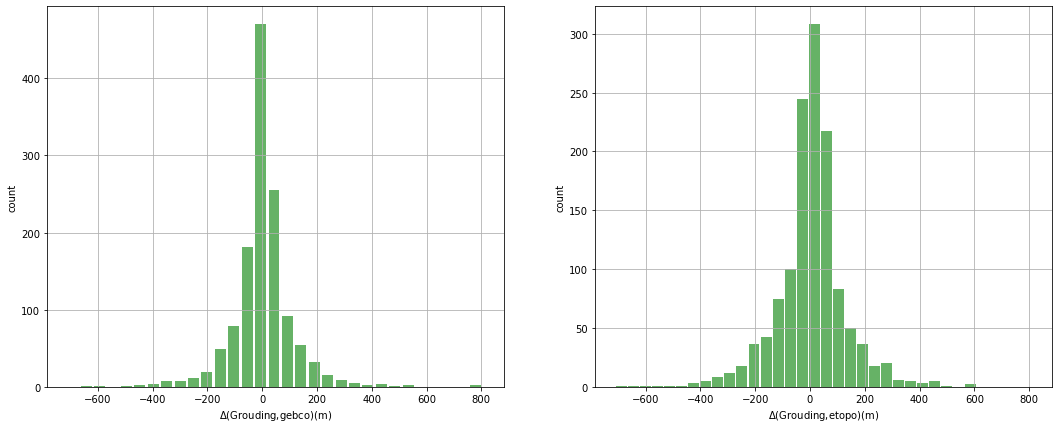

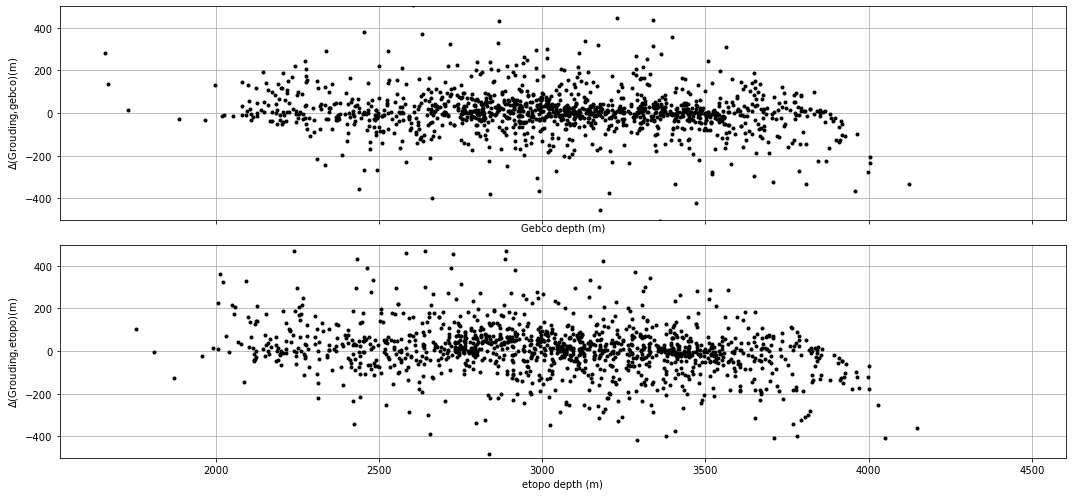

In [125]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

etopo.where((etopo['x']>roi[0]-1)&(etopo['x']<roi[1]+1)&(etopo['y']>roi[2]-1)&(etopo['y']<roi[3]+1),drop=True)['z'].plot(
    vmax=0,cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())
#gebco.where((gebco['lon']>roi[0]-1)&(gebco['lon']<roi[1]+1)&(gebco['lat']>roi[2]-1)&(gebco['lat']<roi[3]+1),drop=True)['elevation'].plot(
#    vmax=0,cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())

ax.scatter(df['LONGITUDE'],df['LATITUDE'],s=10,c='y',transform=ccrs.PlateCarree())
#ax.plot(spread_bathy['lon'],spread_bathy['lat'],'.k',markersize=0.4,transform=ccrs.PlateCarree())
#ax.set_extent([-34.7,-33.5,56.5,57.5])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig, ax = plt.subplots(1,2,figsize=(18,7),sharex=True)

data0 = (df['Zg'].values - spread_bathy['gebco'].mean('PTS')).values
ax[0].hist(data0, bins=30, density=False, alpha=0.6, color='g',width=40)
ax[0].set_xlabel(r'$\Delta$(Grouding,gebco)(m)')
ax[0].set_ylabel('count')

data1 = (df['Zg'].values - spread_bathy['etopo'].mean('PTS')).values
ax[1].hist(data1, bins=30, density=False, alpha=0.6, color='g',width=40)
ax[1].set_xlabel(r'$\Delta$(Grouding,etopo)(m)')
ax[1].set_ylabel('count')

fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
ax[0].plot(spread_bathy['gebco'].mean('PTS'),df['Zg'].values - spread_bathy['gebco'].mean('PTS'),'k.')
ax[0].set_ylim(-500,500)
ax[0].set_ylabel(r'$\Delta$(Grouding,gebco)(m)')
ax[0].set_xlabel('Gebco depth (m)')                 
    
ax[1].plot(spread_bathy['etopo'].mean('PTS'),df['Zg'].values - spread_bathy['etopo'].mean('PTS'),'k.')
ax[1].set_ylim(-500,500)
ax[1].set_ylabel(r'$\Delta$(Grouding,etopo)(m)')
ax[1].set_xlabel('etopo depth (m)')   

plt.tight_layout()